In [47]:
import os

import moviepy.editor as mp
import pandas as pd
import torch
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

In [14]:
TIME_DURATION_IN_SEC = 10
CSV_FILE = './vggsound.csv'

In [15]:
# Rename the columns
new_column_names = {
    '---g-f_I2yQ': 'youtube_video_id',
    '1': 'start_seconds',
    'people marching': 'label',
    'test': 'split',
}

In [16]:
# Rename the columns
df = pd.read_csv(CSV_FILE)
df.rename(columns=new_column_names, inplace=True)

In [17]:
df.head()

,youtube_video_id,start_seconds,label,split
0,--0PQM4-hqg,30,waterfall burbling,train
1,--56QUhyDQM,185,playing tennis,train
2,--5OkAjCI7g,40,people belly laughing,train
3,--8puiAGLhs,30,car engine starting,train
4,--96EN9NUQM,242,alarm clock ringing,train


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [19]:
os.environ["TOKENIZERS_PARALLELISM"] = "false" if device == "cpu" else "true"

In [20]:
CLIP_MODEL_PATH = './data/model'

In [21]:
# Load the CLIP model
if not os.path.exists(os.path.join(CLIP_MODEL_PATH, 'clip_model.pt')):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    torch.save(model.state_dict(), os.path.join(CLIP_MODEL_PATH, 'clip_model.pt'))
else:
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    model.load_state_dict(torch.load(os.path.join(CLIP_MODEL_PATH, 'clip_model.pt')))
    model.to(device)

In [22]:
# Load CLIP processor
if not os.path.exists(os.path.join(CLIP_MODEL_PATH, 'clip_processor')):
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    processor.save_pretrained(os.path.join(CLIP_MODEL_PATH, 'clip_processor'))
else:
    processor = CLIPProcessor.from_pretrained(os.path.join(CLIP_MODEL_PATH, 'clip_processor'))

In [23]:
def extract_best_frame(limit=5):
    for index, row in df.iterrows():
        if index < limit:
            youtube_video_id = row['youtube_video_id']
            label = row['label']
            video_file_path = f"./data/video/video_{youtube_video_id}.mp4"
            audio_file_path = f"./data/audio/audio_{youtube_video_id}.wav"
            if os.path.exists(audio_file_path) and os.path.exists(video_file_path):
                extract_best_image(video_file_path, label, youtube_video_id)

In [24]:
# Function to extract the best image from a video
def extract_best_image(video_path, label, youtube_video_id):
    try:
        # Load the video
        video = mp.VideoFileClip(video_path)
        # Extract video frames
        frames = [frame for frame in video.iter_frames() if frame is not None]
        # Preprocess the text label
        inputs = processor(text=[label], images=frames, return_tensors="pt", padding=True).to(device)

        # Calculate the similarity scores between the text label and each frame
        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            best_match_idx = logits_per_image.argmax().item()

        # Save the best matching frame as an image
        best_frame = frames[best_match_idx]
        output_path = f"./data/image/image_{youtube_video_id}.jpg"
        mp.ImageClip(best_frame).save_frame(output_path)

        # Clean up
        video.close()
    except Exception as e:
        print(f"Error while extracting best frame for video: {youtube_video_id}. Message: {e}")

In [25]:
extract_best_frame(5)

## Can be performed while fetching the objects from a custom dataset

In [49]:
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

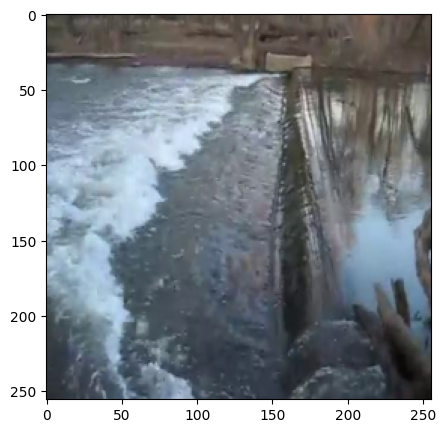

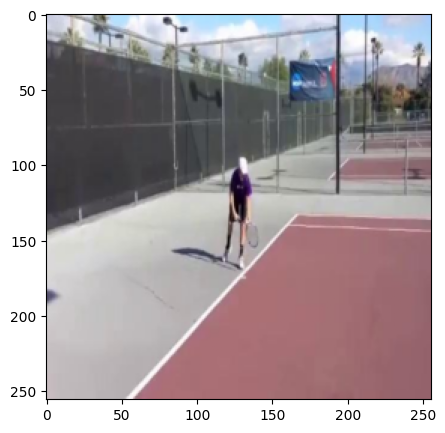

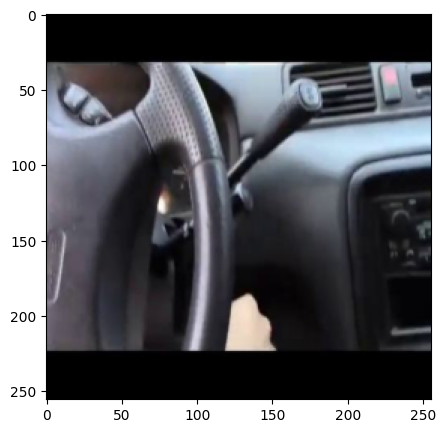

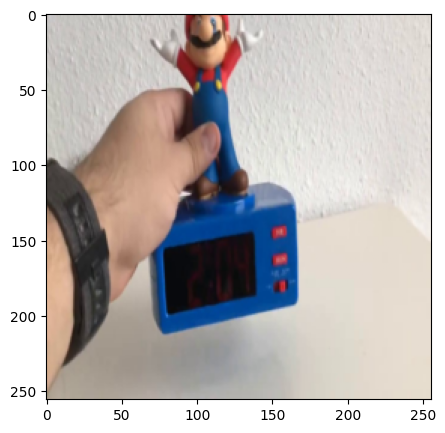

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [55]:
for img_name in os.listdir(os.path.join('data', 'image')):
    img_path = os.path.join(os.path.join('data', 'image', img_name))
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = img_transforms(image)
    inp = image.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(5, 5))
    plt.imshow(inp)
    plt.show()